In [3]:
#%pip install seaborn

In [4]:
# Step 1: Import librerie essenziali
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, ast, re
from scipy.stats import gaussian_kde

plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [15]:
#files = os.listdir('../data')

df = pd.read_excel('/Users/lapotinacci/thesis/metric_datasets/VehicleFlow_dataset.xlsx')
df_names = df['serviceUri'].unique().tolist()
print(df_names)
print(len(df_names))
dati = []
for i, name in enumerate(df_names):
    dati.append(df[df['serviceUri'] == name])
    result = re.sub(r'^.*QA', 'QA', name)
    df_names[i] = result[3:]

['http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO856', 'http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO1113', 'http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO698', 'http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO966', 'http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO1', 'http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO814', 'http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO854']
7


In [16]:
to_keep = ['type_of_TTT', 'min', 'var', 'median', 'mean', 'max', 'linear_trend',
          'avg_variation', 'TTT']

for i in range(len(dati)):
    dati[i] = dati[i][to_keep]

In [17]:

def is_useful_series(series, zero_ratio_thr=0.85, min_nonzero_value=0.1):
    arr = np.array(series, dtype=float)
    
    # Serie troppo corta
    if len(arr) <= 1:
        return False
    
    # Troppi zeri
    zero_ratio = (arr == 0).mean()
    if zero_ratio >= zero_ratio_thr:
        return False
    
    # Valore medio trascurabile (quasi zero)
    mean_val = np.mean(arr)
    if abs(mean_val) < min_nonzero_value:
        return False
    
    # Se arriva qui, la serie ha valori significativi
    return True

In [18]:
cleaned_df = []
for dataset in dati:
    dataset_clean = dataset.copy()
    
    # Filtra righe che non contengono "nan"
    mask = ~dataset_clean['TTT'].str.contains("nan", na=False)
    dataset_clean = dataset_clean[mask]
    
    # Converti stringhe in liste
    dataset_clean['TTT'] = dataset_clean['TTT'].apply(ast.literal_eval)
    
    # Filtra per lunghezza = 24 e rimuovi colonna length
    dataset_clean = (dataset_clean
                    .assign(TTT_length=dataset_clean['TTT'].apply(len))
                    .query('TTT_length == 24')
                    .query('type_of_TTT == "daily"')
                    .drop(columns='TTT_length')
                    .drop(columns=['type_of_TTT'])
                     )
    
    # Filtra serie utili
    #dataset_clean = dataset_clean[dataset_clean['TTT'].apply(is_useful_series)]
    
    
    # Converti la colonna TTT in array numpy (mantenendo il DataFrame)
    dataset_clean['TTT'] = dataset_clean['TTT'].apply(np.array)
    
    cleaned_df.append(dataset_clean)


In [19]:
# Step 3: Statistiche descrittive TTT per ogni metrica
for df in cleaned_df:
    df['TTT_mean'] = df['TTT'].apply(np.mean)
    df['TTT_std'] = df['TTT'].apply(np.std)
    df['TTT_max'] = df['TTT'].apply(np.max)
    df['TTT_min'] = df['TTT'].apply(np.min)
    df['TTT_range'] = df['TTT_max'] - df['TTT_min']

(90, 13)


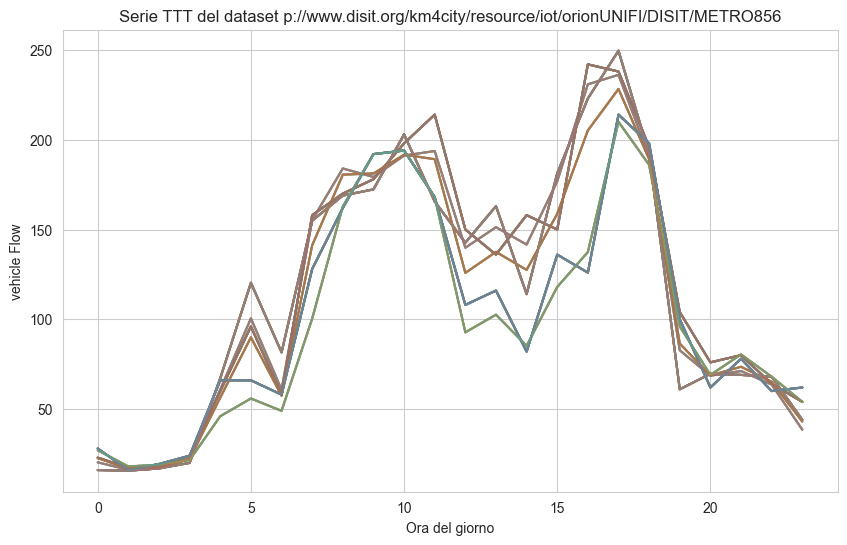

(150, 13)


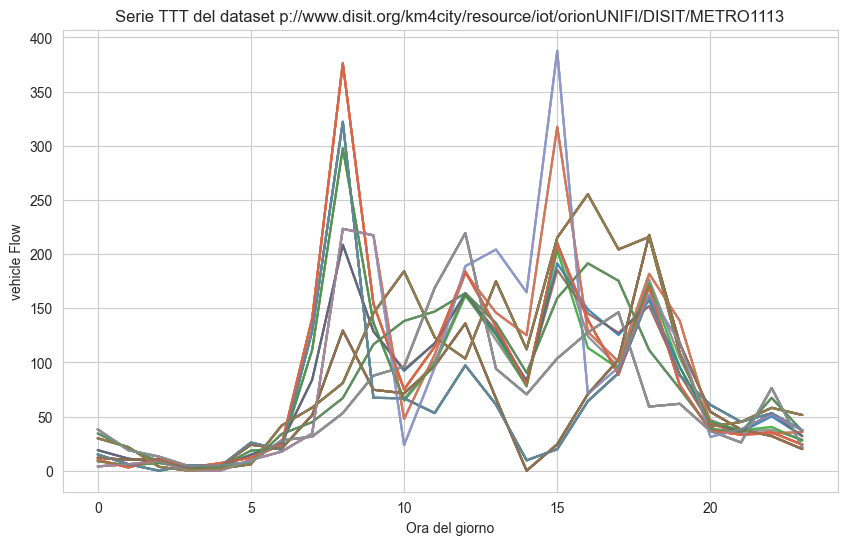

(90, 13)


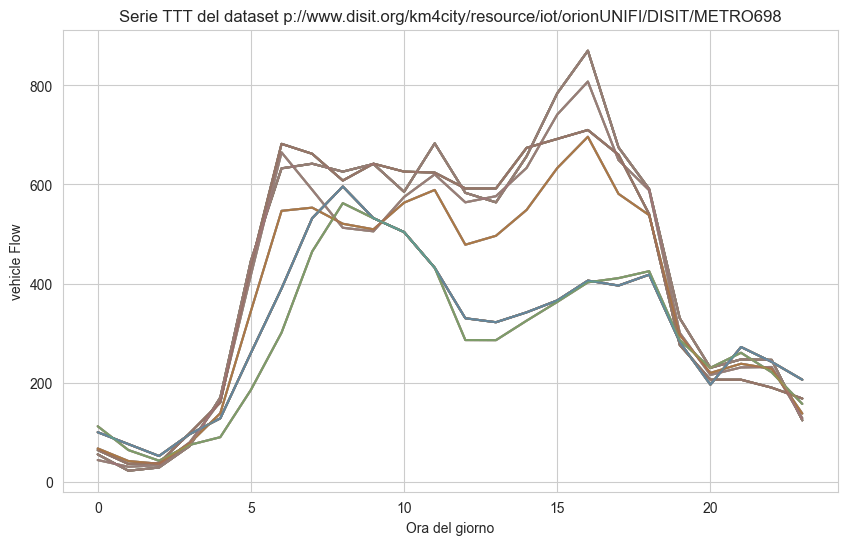

(130, 13)


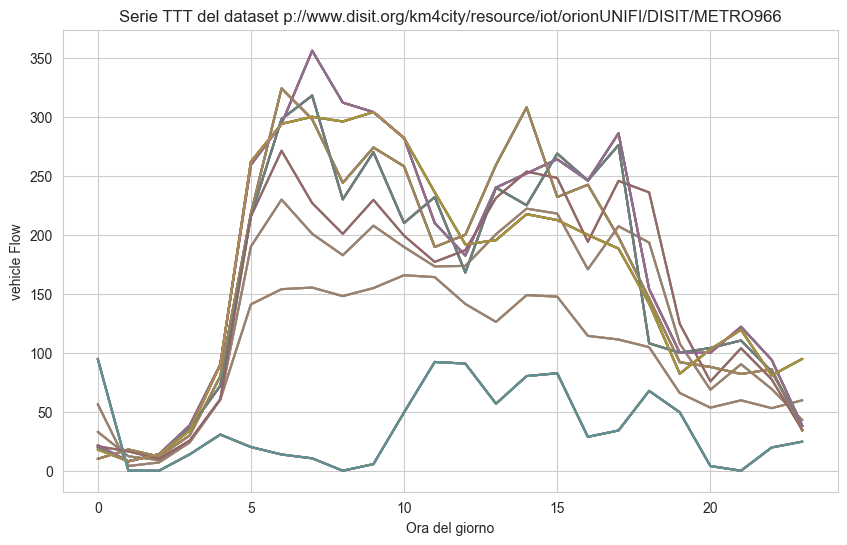

(90, 13)


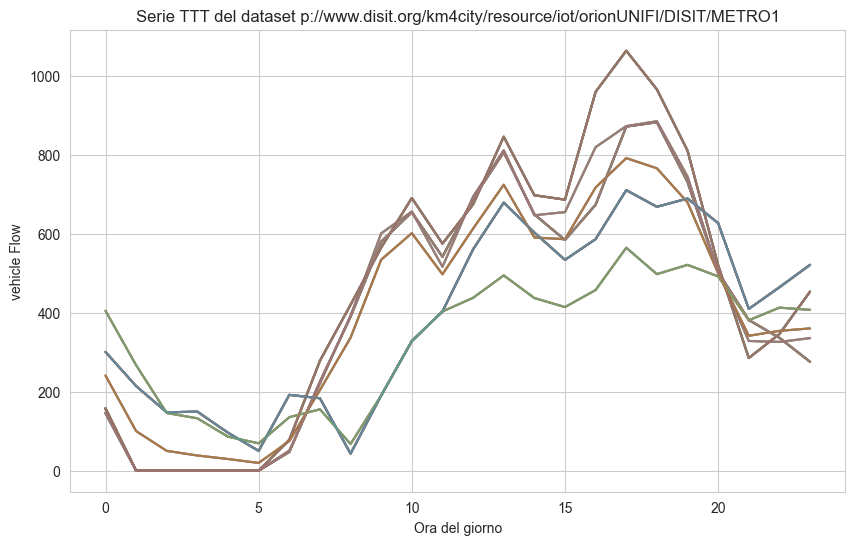

(90, 13)


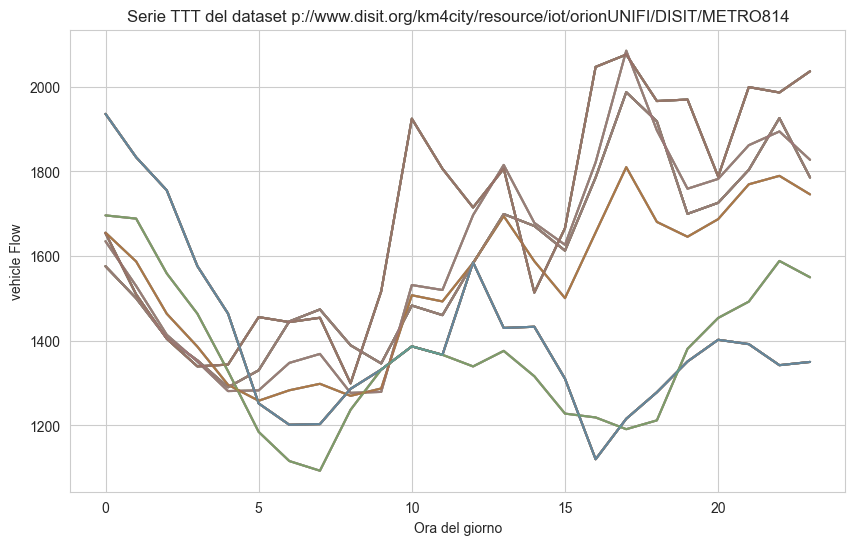

(90, 13)


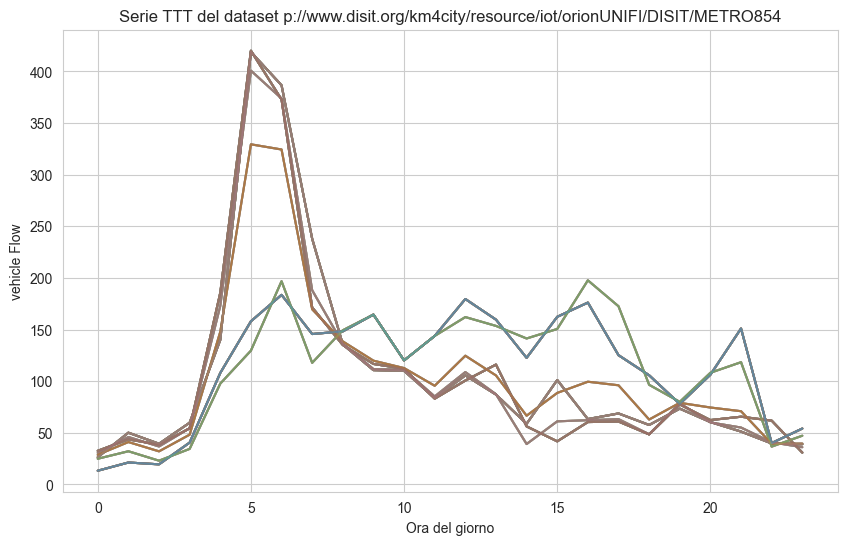

In [20]:
for i, df in enumerate(cleaned_df):
    print(df.shape)
    for ttt in df['TTT']:
        plt.plot(ttt, alpha=0.3)
    plt.title(f'Serie TTT del dataset {df_names[i]}')
    plt.xlabel('Ora del giorno')
    plt.ylabel('vehicle Flow')
    plt.show()

In [11]:
def plot_metric_distributions(df: pd.DataFrame, df_name: str, metrics_list: list, ncols: int = 3):
    """
    Genera una griglia di istogrammi con KDE per ogni metrica specificata.
    Aggiunge un titolo generale che indica il dataset analizzato.
    """
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns

    if not metrics_list:
        print("Nessuna metrica fornita. Impossibile generare i grafici.")
        return
    
    num_metrics = len(metrics_list)
    nrows = math.ceil(num_metrics / ncols)

    fig_height = nrows * 4
    fig_width = ncols * 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))

    # Appiattimento assi
    if num_metrics == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    # Iterazione sui grafici
    for i, metric in enumerate(metrics_list):
        ax = axes_flat[i]

        if metric not in df.columns:
            print(f"Attenzione: La metrica '{metric}' non è nel DataFrame. Salto.")
            ax.text(0.5, 0.5, f"Metrica '{metric}'\nnon trovata",
                    ha='center', va='center')
            ax.set_title(f"Errore: {metric}")
            continue

        sns.histplot(df, x=metric, kde=True, ax=ax)
        ax.set_title(f"Distribuzione di '{metric}'")
        ax.set_xlabel(metric)
        ax.set_ylabel("Frequenza / Densità")

    # Nasconde assi extra se presenti
    for j in range(num_metrics, len(axes_flat)):
        axes_flat[j].axis("off")

    # 💡 Titolo generale della figura
    fig.suptitle(f"Distribuzioni delle Metriche — Dataset: {df_name}", fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()


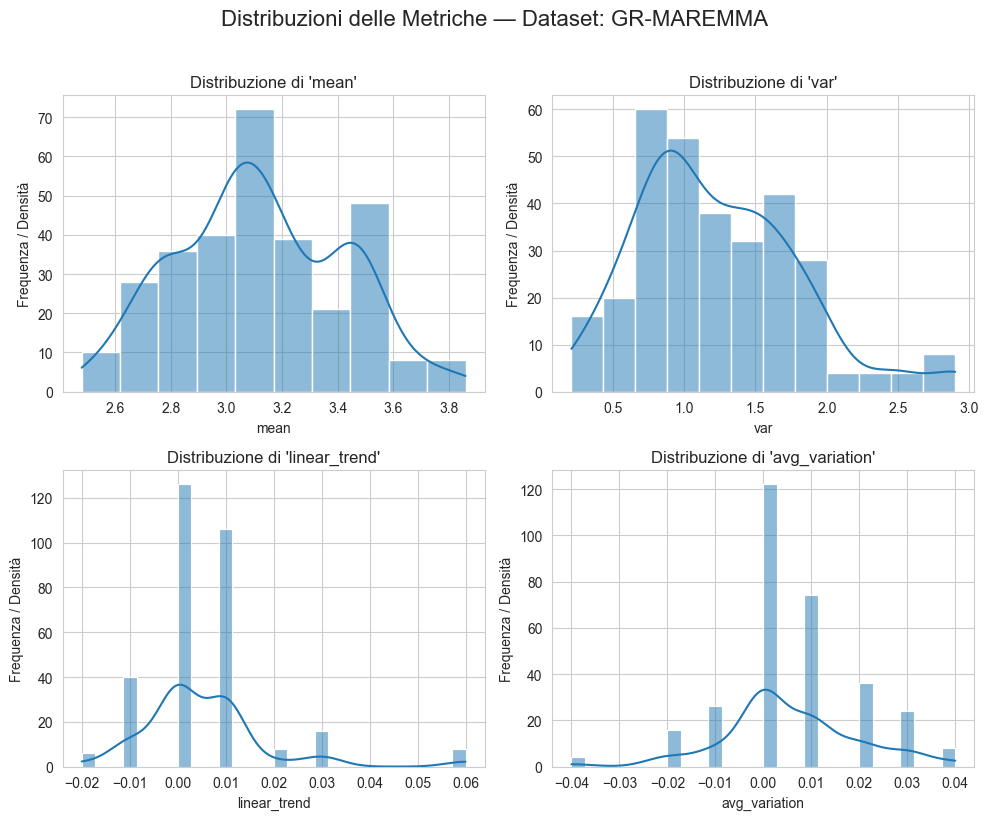

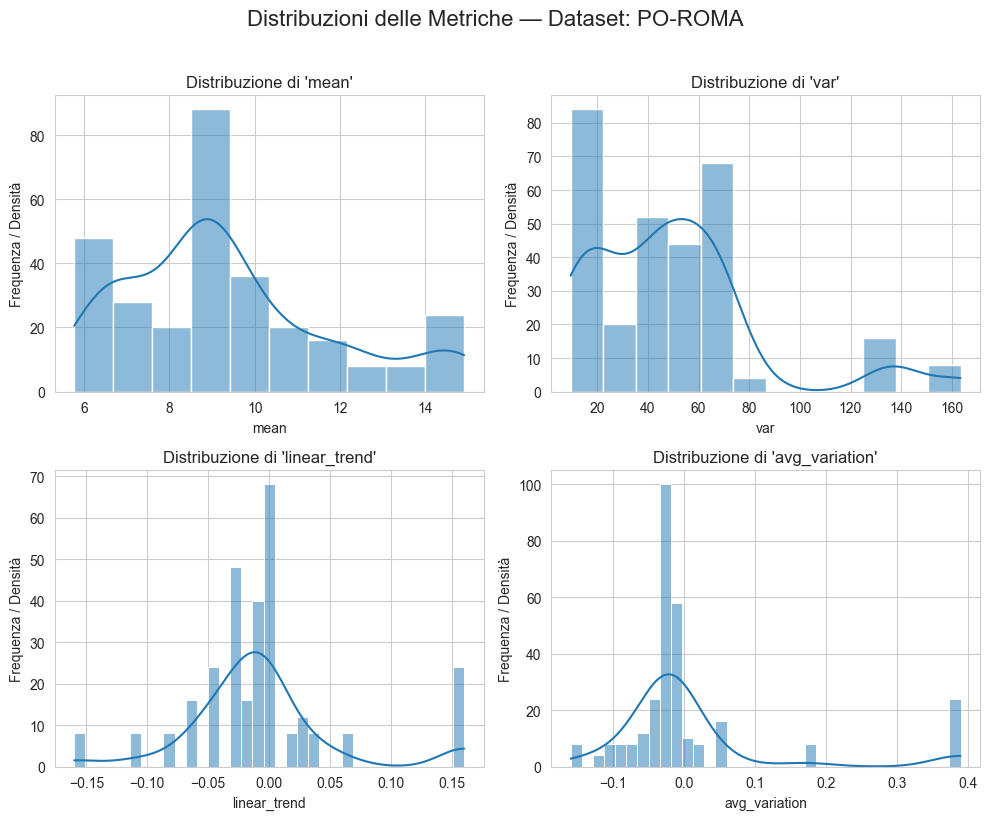

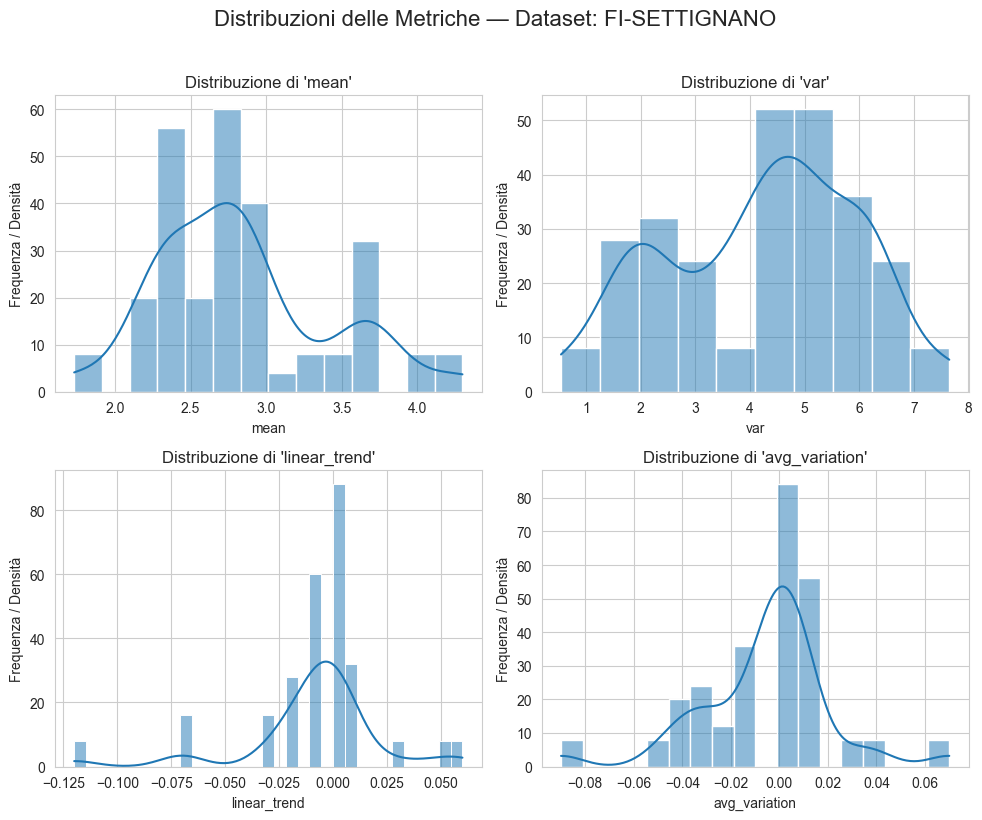

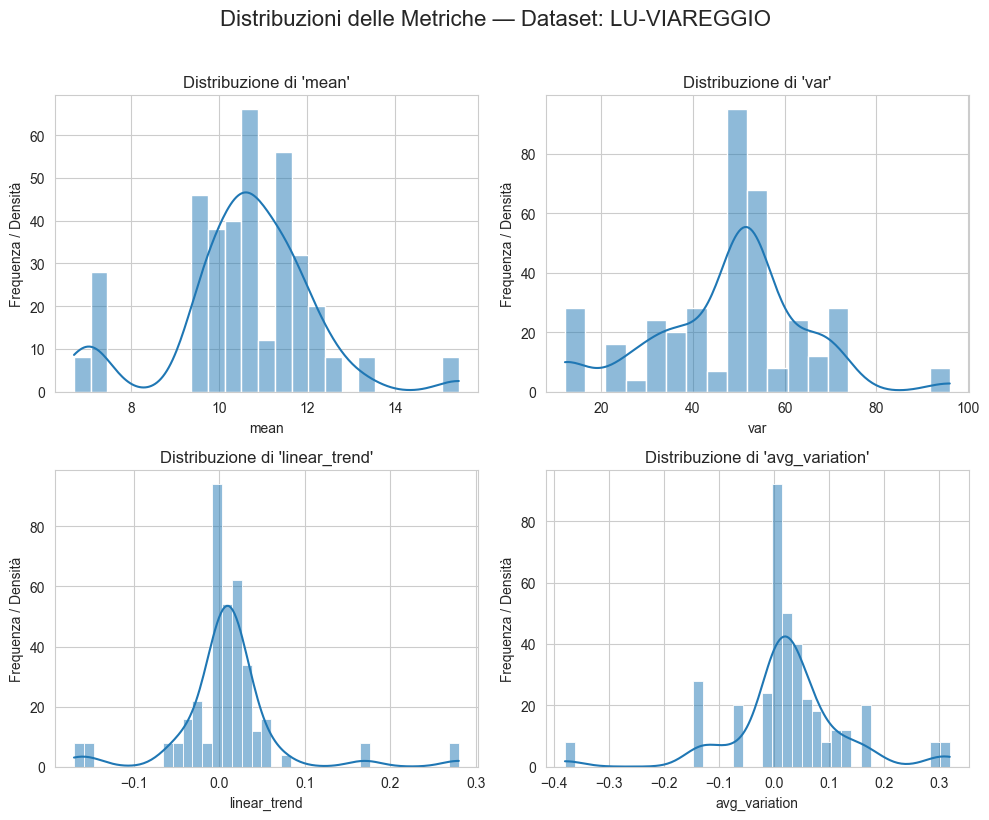

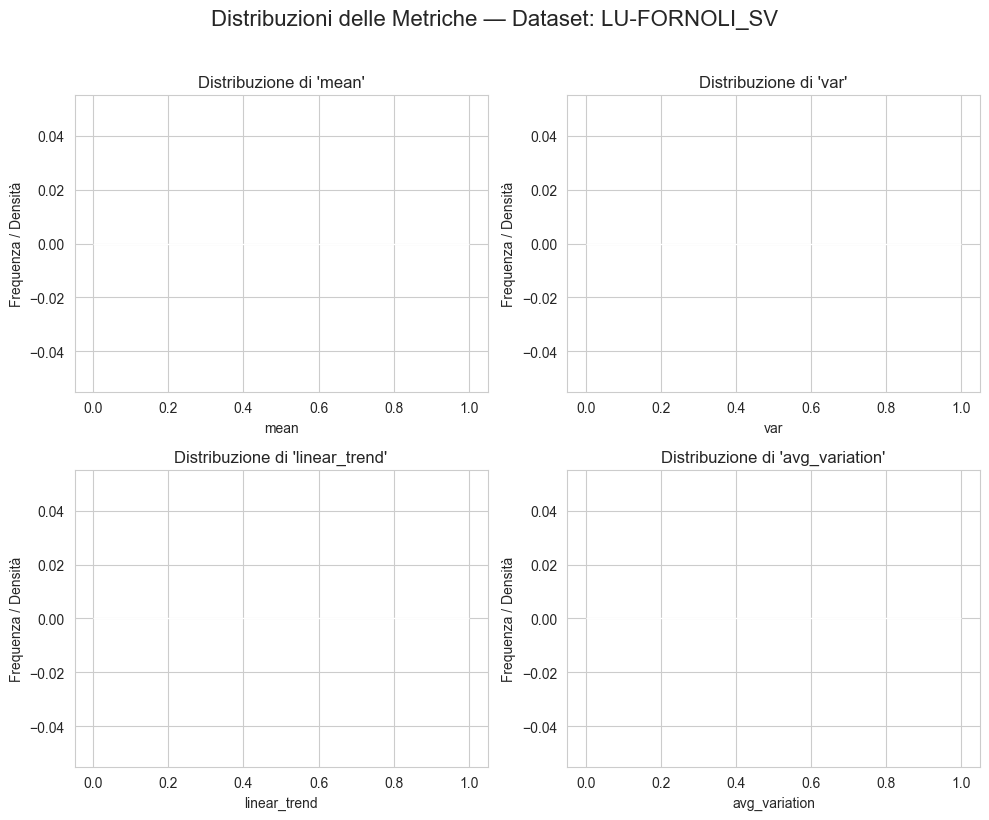

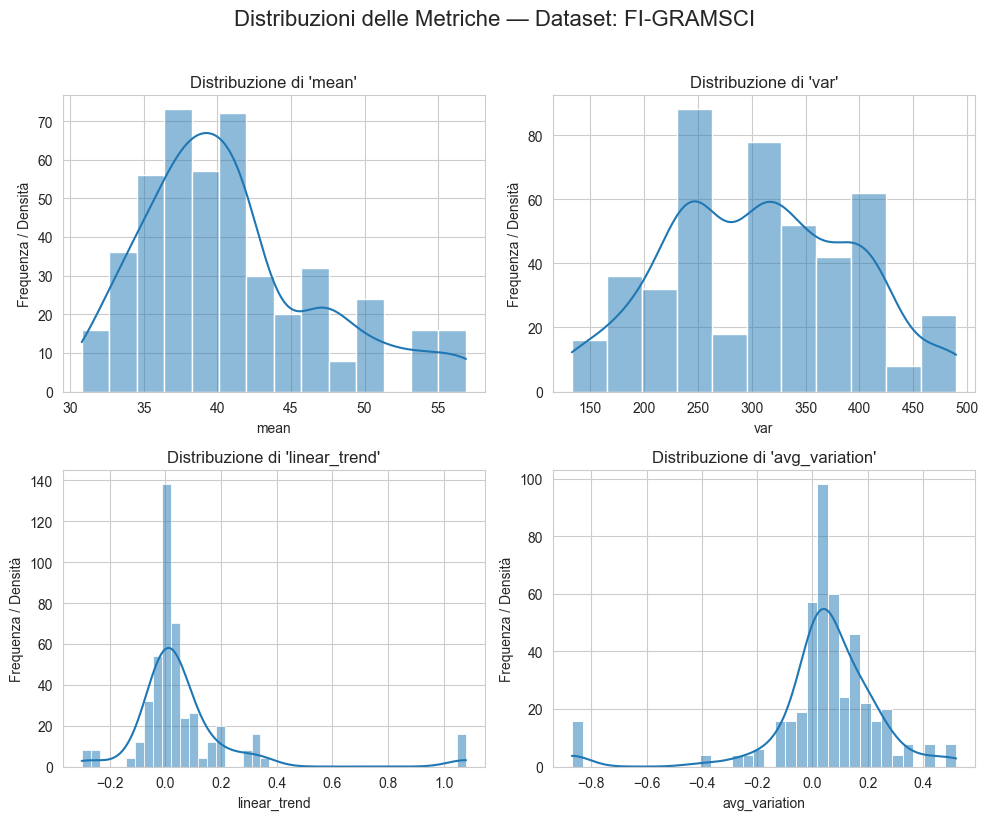

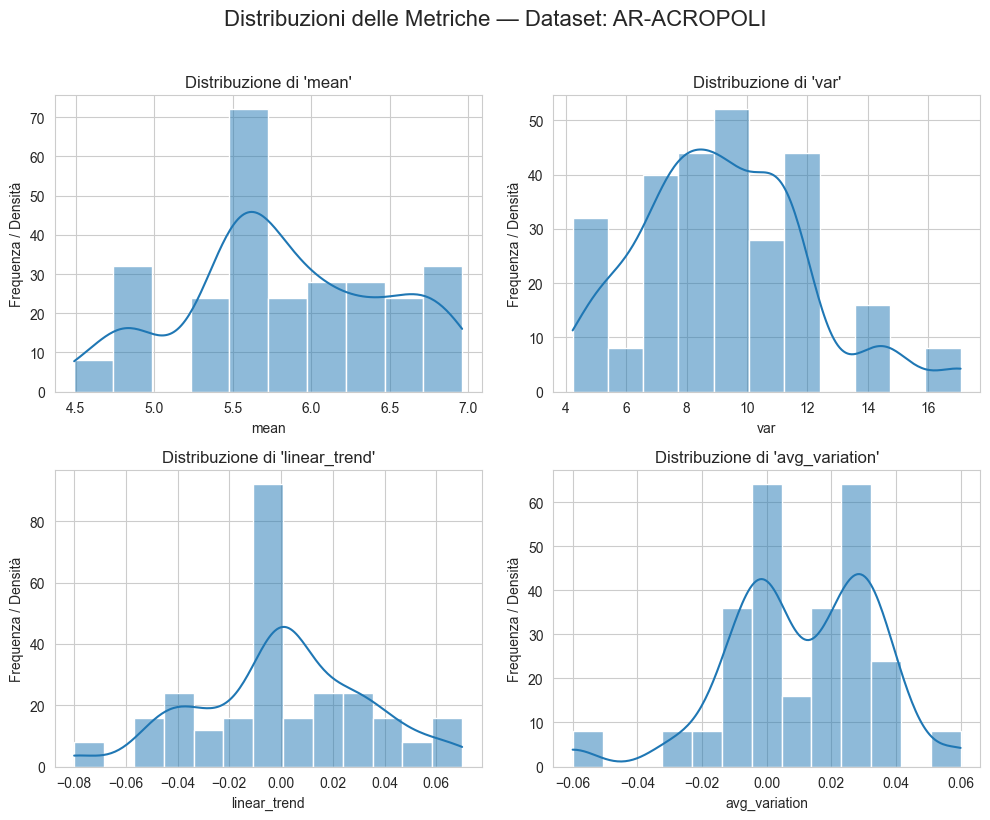

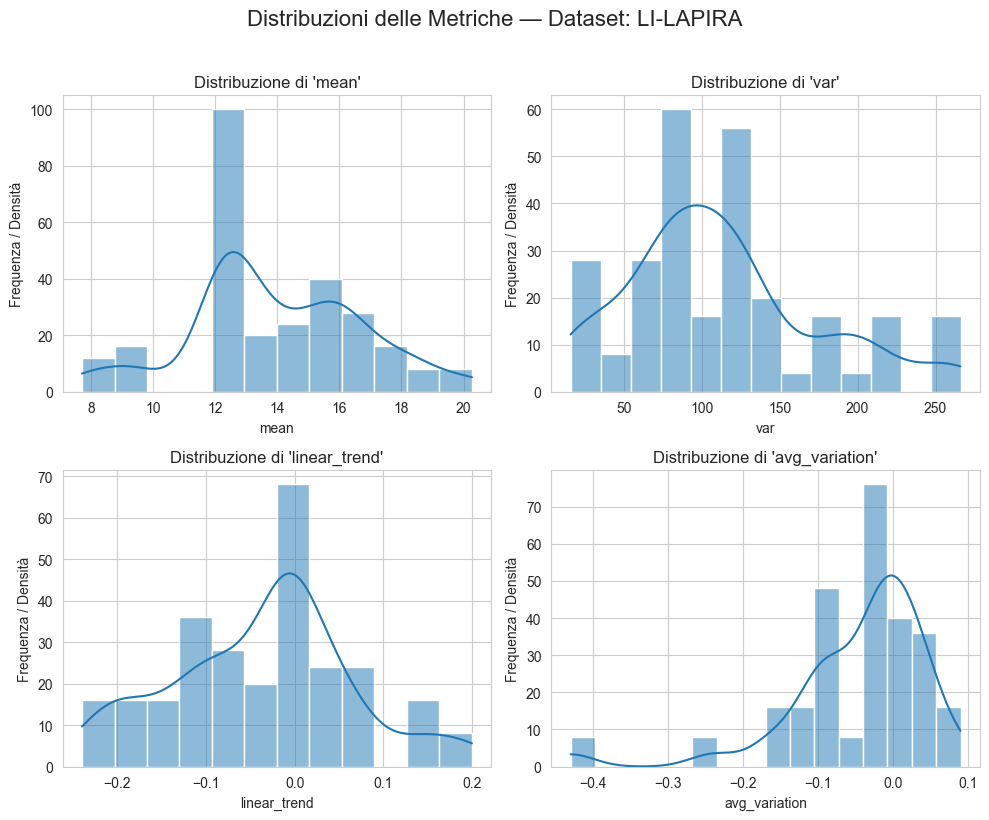

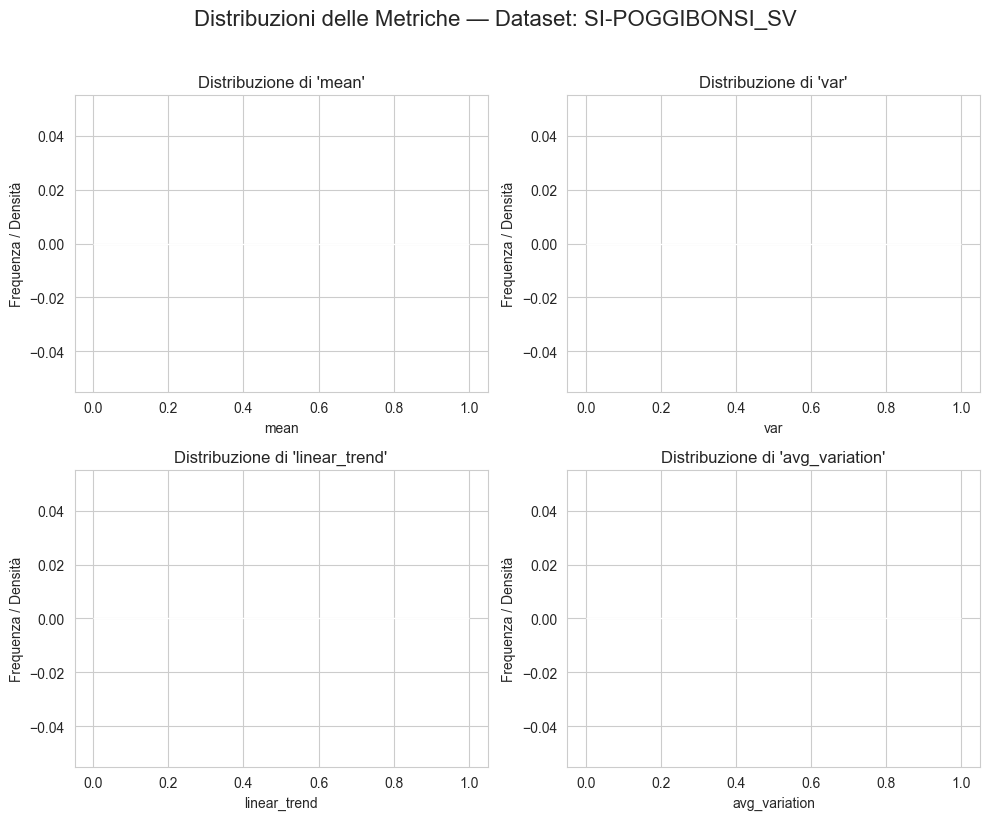

In [12]:
metrics = ['mean', 'var', 'linear_trend', 'avg_variation']
for i, df in enumerate(cleaned_df):
    plot_metric_distributions(df,df_names[i], metrics, ncols=2)

=== ANALISI GRAFICI TTT GLOBALE - GR-MAREMMA ===



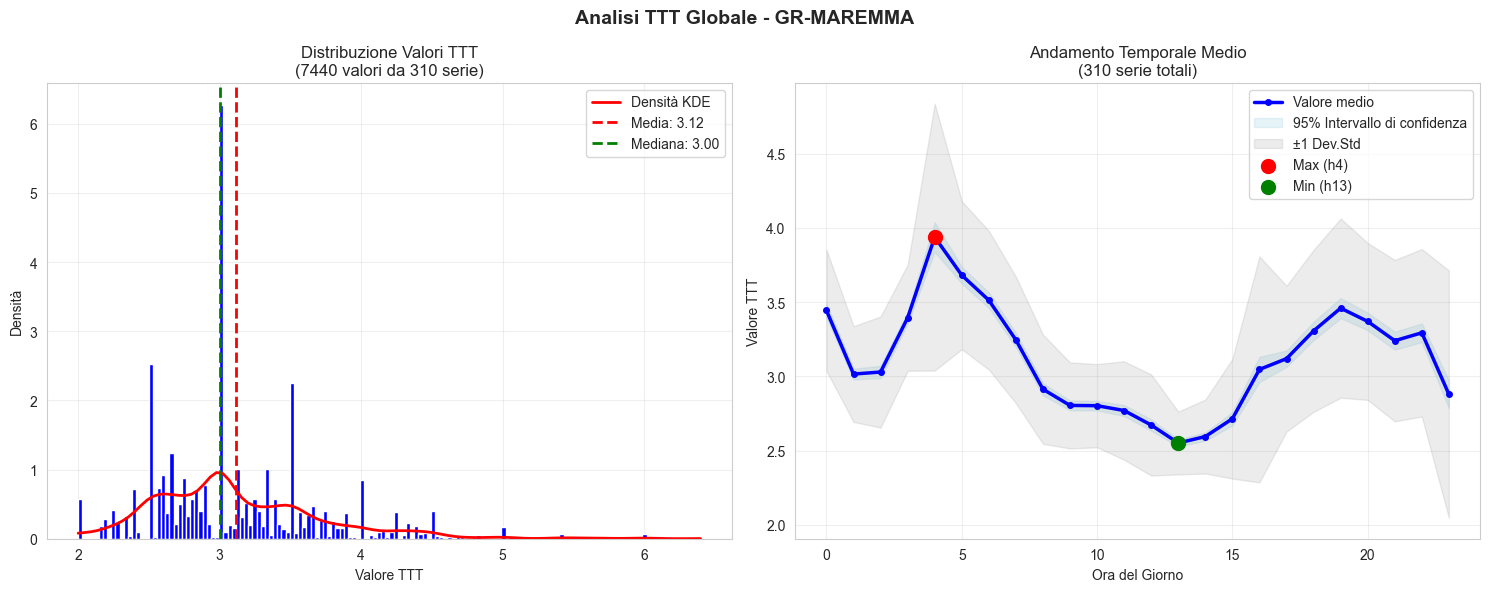

STATISTICHE GLOBALI:
  • Numero serie totali: 310
  • Valori TTT totali: 7440
  • Media: 3.12, Mediana: 3.00, Std: 0.61
  • Min: 2.00, Max: 6.40
  • Picco a h4 (3.94), Minimo a h13 (2.55)
  • Escursione giornaliera: 1.39

=== ANALISI GRAFICI TTT GLOBALE - PO-ROMA ===



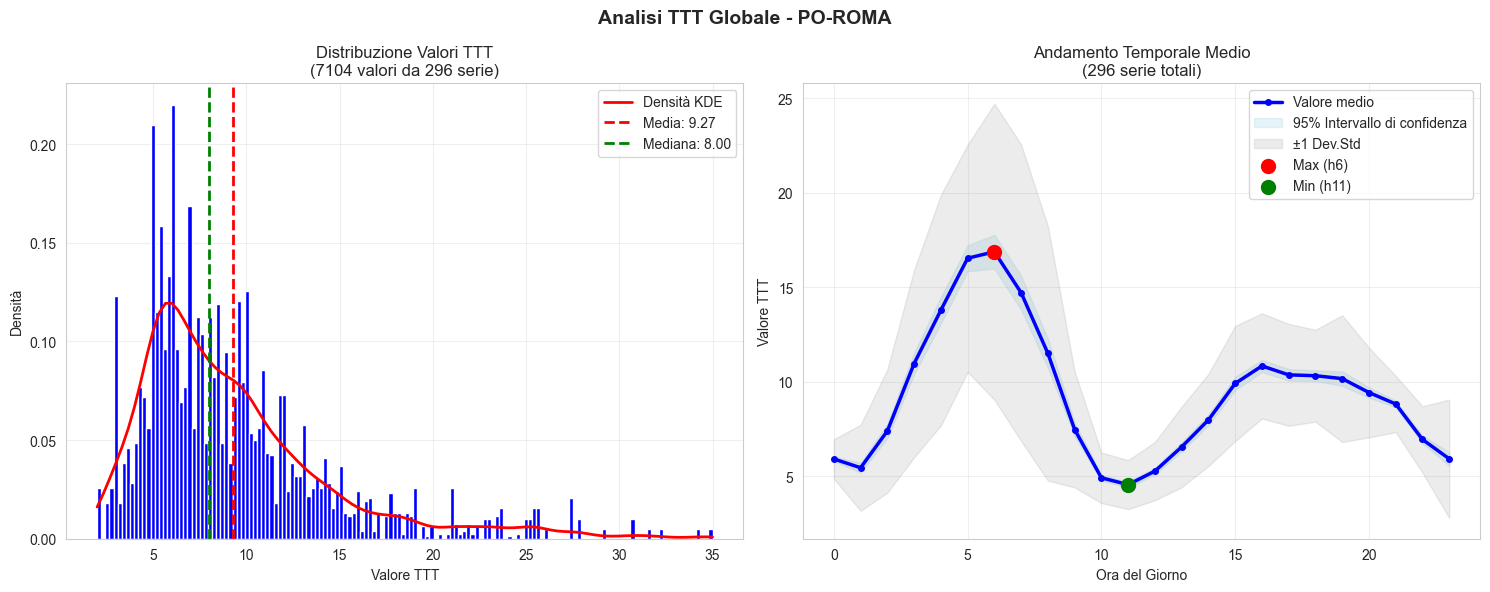

STATISTICHE GLOBALI:
  • Numero serie totali: 296
  • Valori TTT totali: 7104
  • Media: 9.27, Mediana: 8.00, Std: 5.25
  • Min: 2.00, Max: 35.00
  • Picco a h6 (16.88), Minimo a h11 (4.55)
  • Escursione giornaliera: 12.33

=== ANALISI GRAFICI TTT GLOBALE - FI-SETTIGNANO ===



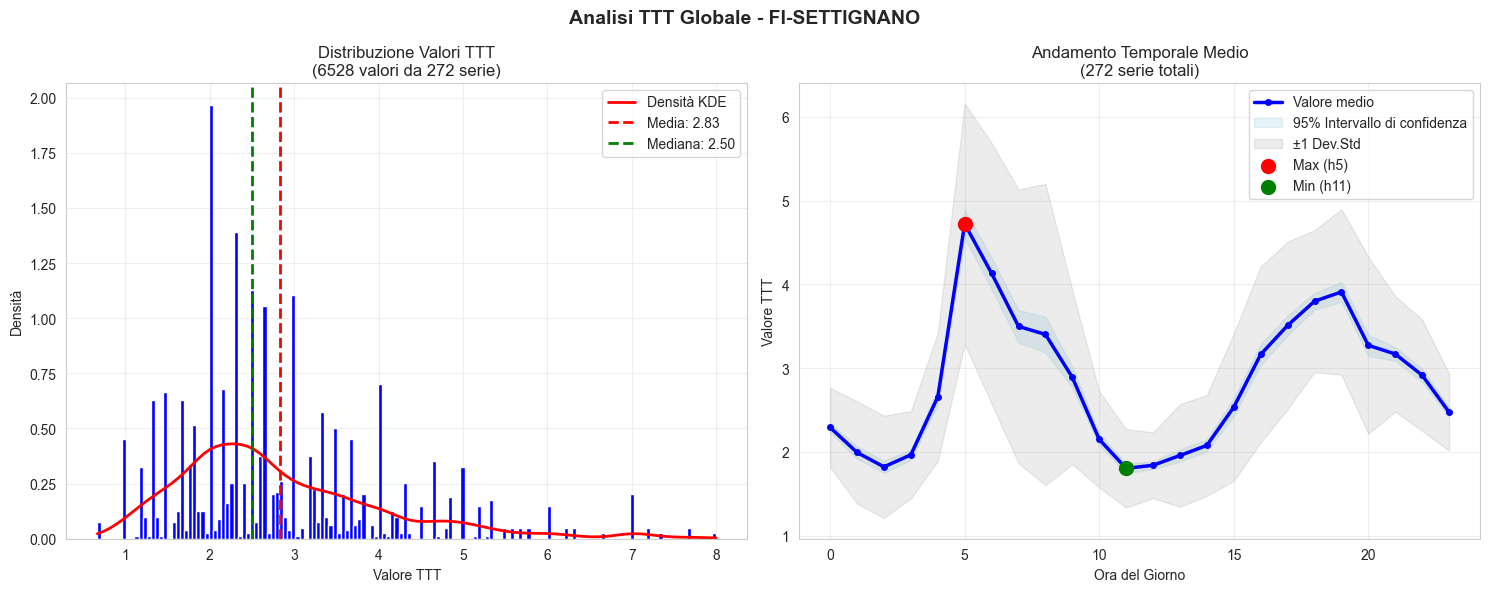

STATISTICHE GLOBALI:
  • Numero serie totali: 272
  • Valori TTT totali: 6528
  • Media: 2.83, Mediana: 2.50, Std: 1.25
  • Min: 0.67, Max: 8.00
  • Picco a h5 (4.72), Minimo a h11 (1.80)
  • Escursione giornaliera: 2.92

=== ANALISI GRAFICI TTT GLOBALE - LU-VIAREGGIO ===



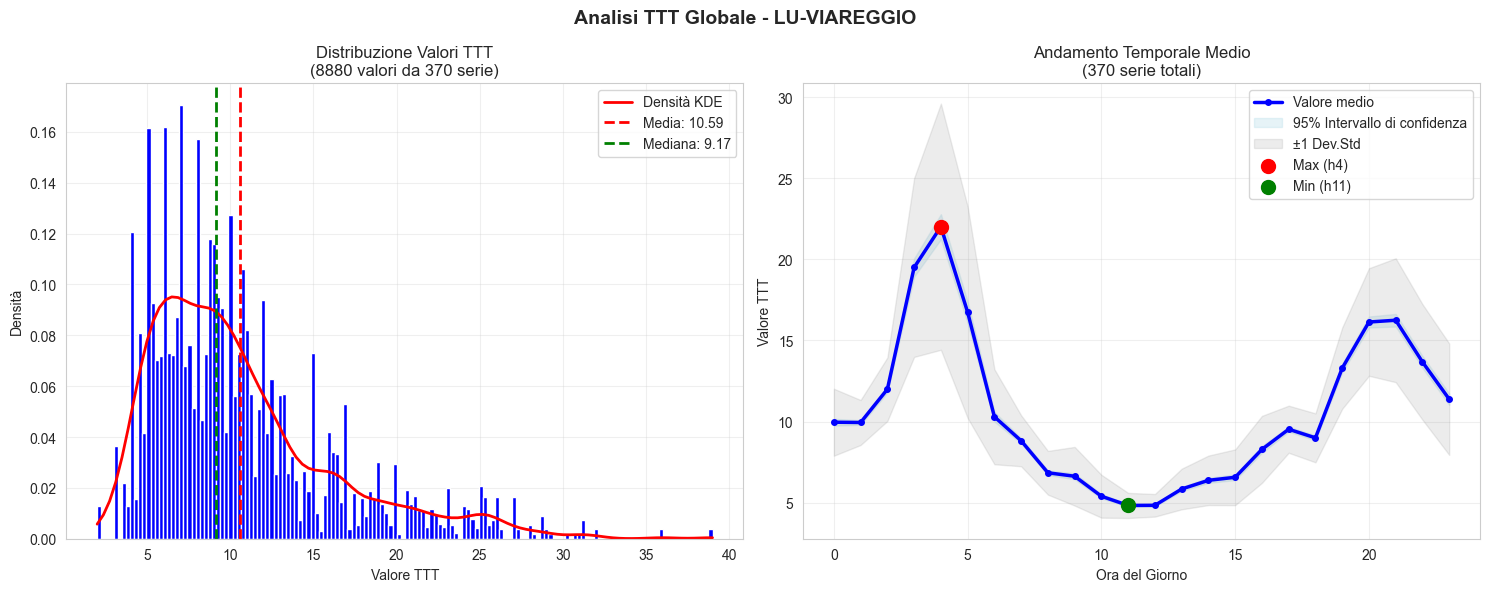

STATISTICHE GLOBALI:
  • Numero serie totali: 370
  • Valori TTT totali: 8880
  • Media: 10.59, Mediana: 9.17, Std: 5.61
  • Min: 2.00, Max: 39.00
  • Picco a h4 (22.02), Minimo a h11 (4.83)
  • Escursione giornaliera: 17.19

=== ANALISI GRAFICI TTT GLOBALE - LU-FORNOLI_SV ===

Nessun dato disponibile nel dataset
=== ANALISI GRAFICI TTT GLOBALE - FI-GRAMSCI ===



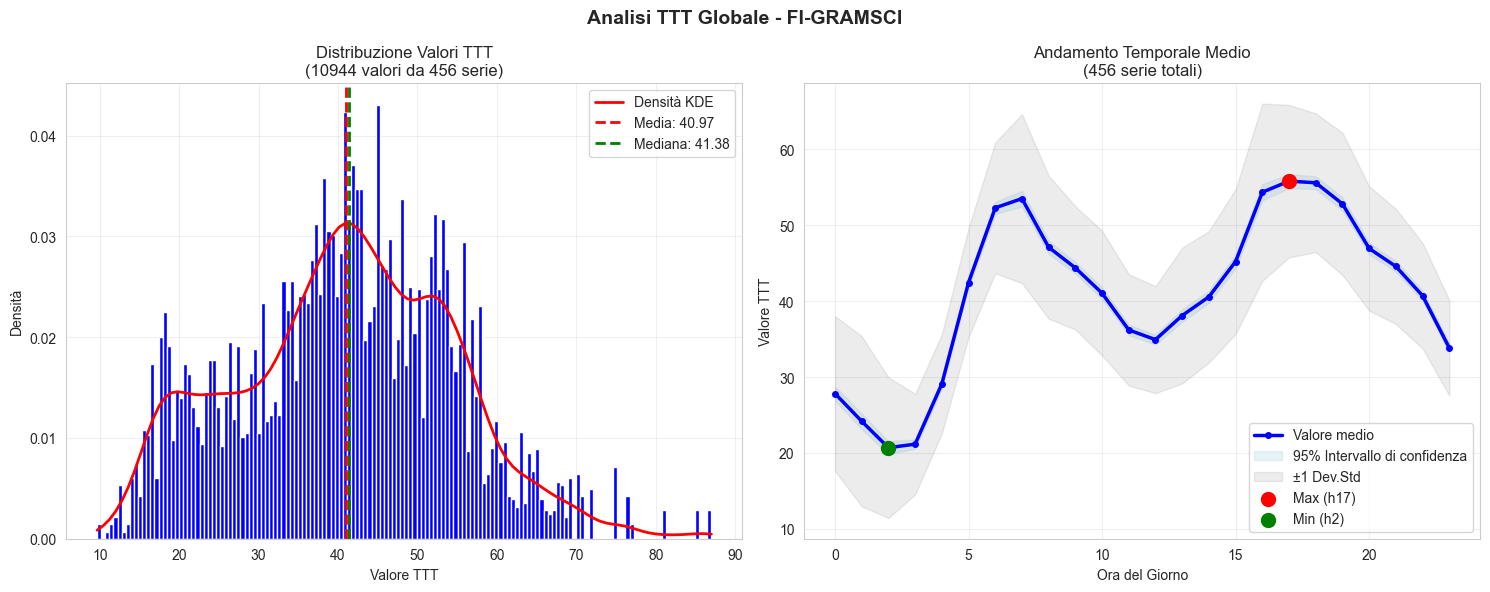

STATISTICHE GLOBALI:
  • Numero serie totali: 456
  • Valori TTT totali: 10944
  • Media: 40.97, Mediana: 41.38, Std: 13.72
  • Min: 9.67, Max: 87.00
  • Picco a h17 (55.80), Minimo a h2 (20.69)
  • Escursione giornaliera: 35.12

=== ANALISI GRAFICI TTT GLOBALE - AR-ACROPOLI ===



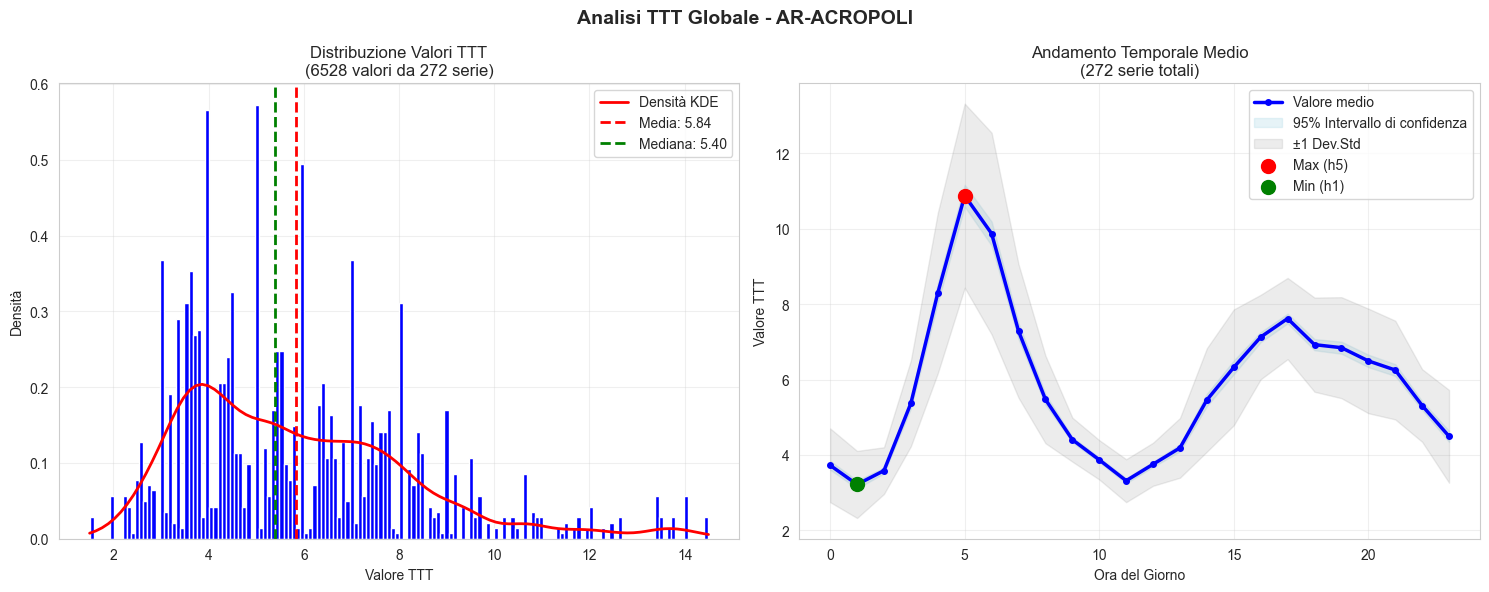

STATISTICHE GLOBALI:
  • Numero serie totali: 272
  • Valori TTT totali: 6528
  • Media: 5.84, Mediana: 5.40, Std: 2.41
  • Min: 1.50, Max: 14.50
  • Picco a h5 (10.88), Minimo a h1 (3.22)
  • Escursione giornaliera: 7.66

=== ANALISI GRAFICI TTT GLOBALE - LI-LAPIRA ===



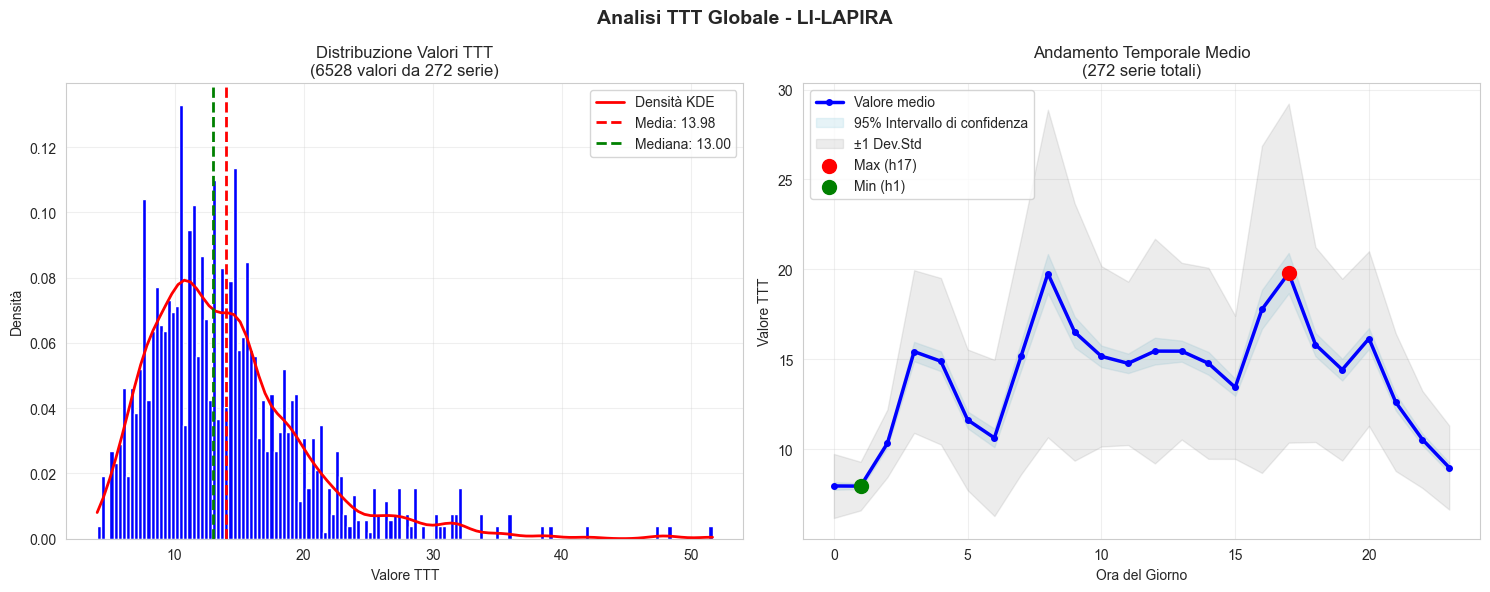

STATISTICHE GLOBALI:
  • Numero serie totali: 272
  • Valori TTT totali: 6528
  • Media: 13.98, Mediana: 13.00, Std: 6.26
  • Min: 4.00, Max: 51.67
  • Picco a h17 (19.79), Minimo a h1 (7.96)
  • Escursione giornaliera: 11.84

=== ANALISI GRAFICI TTT GLOBALE - SI-POGGIBONSI_SV ===

Nessun dato disponibile nel dataset


In [13]:
def plot_ttt_analysis_global(df, nome_dataset="Dataset"):
    """
    Crea grafici della distribuzione TTT e andamento medio con intervallo di confidenza
    per l'intero dataset (senza distinzione tra metriche)
    
    Parameters:
    - df: DataFrame con colonne 'metric' e 'TTT'
    - nome_dataset: nome del dataset per i titoli
    """
    
    print(f"=== ANALISI GRAFICI TTT GLOBALE - {nome_dataset} ===\n")
    
    if len(df) == 0:
        print("Nessun dato disponibile nel dataset")
        return
    
    # Prepara i dati usando TUTTE le serie del dataset
    all_ttt_values = np.concatenate(df['TTT'].values)
    series_matrix = np.vstack(df['TTT'].values)
    hourly_mean = series_matrix.mean(axis=0)
    hourly_std = series_matrix.std(axis=0)
    hours = np.arange(len(hourly_mean))
    
    # Calcola intervallo di confidenza 95%
    n_series = len(df)
    sem = hourly_std / np.sqrt(n_series)
    ci_95 = 1.96 * sem
    
    # Crea figura con due subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Analisi TTT Globale - {nome_dataset}', 
                 fontsize=14, fontweight='bold')
    
    # --- GRAFICO 1: Distribuzione valori TTT ---
    ax1.hist(all_ttt_values, bins=150, color='blue', 
            density=True)
    
    # Aggiungi curva di densità con gestione errore
    if len(all_ttt_values) > 1:
        try:
            # Controlla se la varianza è troppo piccola
            if np.std(all_ttt_values) < 1e-6:
                print(" Varianza troppo piccola per KDE - uso solo istogramma")
            else:
                # Aggiungi un piccolo rumore per evitare singolarità
                noisy_data = all_ttt_values + np.random.normal(0, np.std(all_ttt_values)/100, len(all_ttt_values))
                kde = gaussian_kde(noisy_data)
                x_range = np.linspace(all_ttt_values.min(), all_ttt_values.max(), 100)
                ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densità KDE')
        except Exception as e:
            print(f"  Impossibile calcolare KDE: {e}")
    
    # Statistiche principali
    mean_val = np.mean(all_ttt_values)
    median_val = np.median(all_ttt_values)
    
    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Media: {mean_val:.2f}')
    ax1.axvline(median_val, color='green', linestyle='--', linewidth=2, 
               label=f'Mediana: {median_val:.2f}')
    
    ax1.set_title(f'Distribuzione Valori TTT\n({len(all_ttt_values)} valori da {n_series} serie)')
    ax1.set_xlabel('Valore TTT')
    ax1.set_ylabel('Densità')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- GRAFICO 2: Andamento temporale medio con IC ---
    # Linea media
    ax2.plot(hours, hourly_mean, color='blue', linewidth=2.5, 
            label='Valore medio', marker='o', markersize=4)
    
    # Intervallo di confidenza 95%
    ax2.fill_between(hours,
                    hourly_mean - ci_95,
                    hourly_mean + ci_95,
                    alpha=0.3, color='lightblue', 
                    label='95% Intervallo di confidenza')
    
    # Deviazione standard (opzionale, più leggera)
    ax2.fill_between(hours, 
                    hourly_mean - hourly_std, 
                    hourly_mean + hourly_std, 
                    alpha=0.15, color='gray', 
                    label='±1 Dev.Std')
    
    # Identifica punti di interesse
    max_hour = np.argmax(hourly_mean)
    min_hour = np.argmin(hourly_mean)
    
    ax2.scatter([max_hour], [hourly_mean[max_hour]], 
               color='red', s=100, zorder=5, label=f'Max (h{max_hour})')
    ax2.scatter([min_hour], [hourly_mean[min_hour]], 
               color='green', s=100, zorder=5, label=f'Min (h{min_hour})')
    
    ax2.set_title(f'Andamento Temporale Medio\n({n_series} serie totali)')
    ax2.set_xlabel('Ora del Giorno')
    ax2.set_ylabel('Valore TTT')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiche rapide
    print(f"STATISTICHE GLOBALI:")
    print(f"  • Numero serie totali: {n_series}")
    print(f"  • Valori TTT totali: {len(all_ttt_values)}")
    print(f"  • Media: {mean_val:.2f}, Mediana: {median_val:.2f}, Std: {np.std(all_ttt_values):.2f}")
    print(f"  • Min: {np.min(all_ttt_values):.2f}, Max: {np.max(all_ttt_values):.2f}")
    print(f"  • Picco a h{max_hour} ({hourly_mean[max_hour]:.2f}), Minimo a h{min_hour} ({hourly_mean[min_hour]:.2f})")
    print(f"  • Escursione giornaliera: {hourly_mean[max_hour] - hourly_mean[min_hour]:.2f}\n")


for i, dataset in enumerate(cleaned_df):
    plot_ttt_analysis_global(dataset, nome_dataset=df_names[i])

In [14]:
# Report riassuntivo finale 
print("=== REPORT RIASSUNTIVO FINALE ===")

print("📋 SINTESI COMPLETA ANALISI TTT")

for i, df in enumerate(cleaned_df):
    print(f"\n DATASET {df_names[i]}:")
    print("-" * 40)
    
    if len(df) > 0:
        # Calcola andamento temporale per le statistiche
        series_matrix = np.vstack(df['TTT'].values)
        hourly_mean = series_matrix.mean(axis=0)
        max_hour = np.argmax(hourly_mean)
        min_hour = np.argmin(hourly_mean)
        
        # Statistiche generali
        global_mean = df['TTT_mean'].mean()
        global_std = df['TTT_std'].mean()
        
        print(f"• Serie totali: {len(df)}")
        print(f"• Valore medio TTT: {global_mean:.2f}")
        print(f"• Variabilità media: {global_std:.2f}")
        print(f"• Picco massimo: h{max_hour} ({hourly_mean[max_hour]:.1f})")
        print(f"• Minimo: h{min_hour} ({hourly_mean[min_hour]:.1f})")
        print(f"• Escursione giornaliera: {hourly_mean[max_hour] - hourly_mean[min_hour]:.1f}")
    
    print("-" * 40)

=== REPORT RIASSUNTIVO FINALE ===
📋 SINTESI COMPLETA ANALISI TTT

 DATASET GR-MAREMMA:
----------------------------------------
• Serie totali: 310
• Valore medio TTT: 3.12
• Variabilità media: 0.50
• Picco massimo: h4 (3.9)
• Minimo: h13 (2.6)
• Escursione giornaliera: 1.4
----------------------------------------

 DATASET PO-ROMA:
----------------------------------------
• Serie totali: 296
• Valore medio TTT: 9.27
• Variabilità media: 4.40
• Picco massimo: h6 (16.9)
• Minimo: h11 (4.5)
• Escursione giornaliera: 12.3
----------------------------------------

 DATASET FI-SETTIGNANO:
----------------------------------------
• Serie totali: 272
• Valore medio TTT: 2.83
• Variabilità media: 1.06
• Picco massimo: h5 (4.7)
• Minimo: h11 (1.8)
• Escursione giornaliera: 2.9
----------------------------------------

 DATASET LU-VIAREGGIO:
----------------------------------------
• Serie totali: 370
• Valore medio TTT: 10.59
• Variabilità media: 5.25
• Picco massimo: h4 (22.0)
• Minimo: h11 (4